<img src="data/photutils_banner.svg" width=500 alt="Photutils logo" style="margin-left: 0;">

<div class="alert alert-block alert-info">
<h2 style="margin-top: 0">In this notebook, we will cover:</h2>

- The basics to perform aperture photometry with the aperture_photometry() function
- Aperture photometry (and other properties) with the ApertureStats class

This notebook builds on the previous tutorials for Astropy Units/Quantities, Coordinates, FITS, and Tables.
</div>

## Preliminaries

In [1]:
# Initial imports
import numpy as np
import matplotlib.pyplot as plt

# Change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'

# Run the %matplotlib magic command to enable inline plotting
# in the current notebook.  Choose one of these:
%matplotlib inline
# %matplotlib notebook

### Load the data

We'll start by reading science data and error arrays from FITS files located in the [**data/**](data) subdirectory.  The FITS files contain 2D cutout images from the [Hubble Extreme-Deep Field (XDF)](https://archive.stsci.edu/prepds/xdf/) taken with the [Wide Field Camera 3 (WFC3)](https://www.stsci.edu/hst/instrumentation/wfc3) IR channel in the F160W filter (centered at ~1.6 $\mu m$).

In [2]:
from astropy.io import fits

sci_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_sci.fits'
rms_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_rms.fits'
sci_hdulist = fits.open(sci_fn)
rms_hdulist = fits.open(rms_fn)

Let's print some information about the science data.

In [3]:
sci_hdulist.info()

Filename: data/xdf_hst_wfc3ir_60mas_f160w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (200, 200)   float32   


The data array is in the **`0`** extension, has a shape of `200 x 200` pixels, and has a data type of `float32` (32 bit floating-point numbers).

Let's extract the data and error arrays.

In [4]:
data = sci_hdulist[0].data.astype(float)
error = rms_hdulist[0].data.astype(float)

`data` and `error` are now 2D [numpy](https://numpy.org) arrays, each with a shape of 200 x 200 pixels.

In [5]:
data.shape, error.shape

((200, 200), (200, 200))

Now let's extract the data header and create an Astropy [World Coordinate System (WCS)](https://docs.astropy.org/en/stable/wcs/index.html) object from the FITS header WCS information.

In [6]:
from astropy.wcs import WCS

hdr = sci_hdulist[0].header
wcs = WCS(hdr)

Finally, let's display the science image.  Here we use the [astropy.visualization](https://docs.astropy.org/en/stable/visualization/index.html) subpackage to apply a square-root stretch to the data.

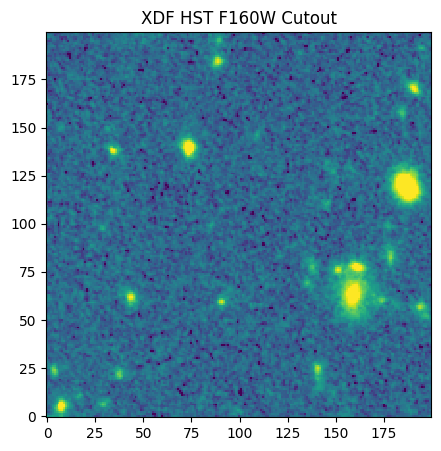

In [7]:
from astropy.visualization import simple_norm

plt.figure(figsize=(5, 5))
norm = simple_norm(data, 'sqrt', percent=99.0)
plt.imshow(data, norm=norm)
plt.title('XDF HST F160W Cutout');

# Aperture Objects

Photutils provides circular, elliptical, and rectangular aperture shapes (plus annulus versions of each).

Further, there are two types of aperture classes, defined either with pixel or sky (celestial) coordinates.

These are the names of the [aperture classes](https://photutils.readthedocs.io/en/latest/aperture.html#classes) that are defined in pixel coordinates:

* `CircularAperture`
* `CircularAnnulus`

* `EllipticalAperture`
* `EllipticalAnnulus`

* `RectangularAperture`
* `RectangularAnnulus`

The aperture classes defined in celestial coordinates have `Sky` prepended to their names:

* `SkyCircularAperture`
* `SkyCircularAnnulus`

* `SkyEllipticalAperture`
* `SkyEllipticalAnnulus`

* `SkyRectangularAperture`
* `SkyRectangularAnnulus`


The aperture shapes look like this:
<img src='data/apertures.png' alt='Figure of aperture shapes' width=700px>

## Methods for handling aperture/pixel overlap

The apertures will usually only partially overlap some of the pixels in the data.

Photutils apertures provide three methods for handling the aperture overlap with the pixel grid of the data array.

<img src="data/photutils_aperture_methods.svg">

For the default method (`method='exact'`), the exact fractional overlap of the aperture with each pixel is calculated. Each pixel is then weighted by the exact fractional overlap of the aperture.

For `method='center'`, a pixel is considered to be entirely in or out of the aperture depending on whether its center is located within the aperture.

For `method='subpixel'`, pixels are divided into a number of subpixels, which are in or out of the aperture based on their centers. Each pixel is then weighted by its fraction of subpixel overlaps. For this method, the number of subpixels needs to be set with the `subpixels` keyword. The `subpixels` keyword is ignored for the `'exact'` and `'center'` methods.

## Creating Aperture Objects

First, let's define a circular aperture at a given (x, y) pixel position and radius (in pixels).

Photutils has many tools for detecting sources (e.g., see [photutils.detection](https://photutils.readthedocs.io/en/latest/detection.html) and [photutils.segmentation](https://photutils.readthedocs.io/en/latest/segmentation.html)) and measuring source positions (e.g., [photutils.centroids](https://photutils.readthedocs.io/en/latest/centroids.html)). For this example, we'll assume we've already measured the source centroid.

In [8]:
from photutils.aperture import CircularAperture

position = (90.73, 59.43)  # (x, y) centroid position (pixels)
radius = 5.0  # pixels
aperture = CircularAperture(position, r=radius)

Our `aperture` variable is now an instance of a [CircularAperture](https://photutils.readthedocs.io/en/latest/api/photutils.aperture.CircularAperture.html#photutils.aperture.CircularAperture) object.

In [9]:
aperture

<CircularAperture([90.73, 59.43], r=5.0)>

We can plot the aperture on the data using its `plot()` method, with a custom color and line width.

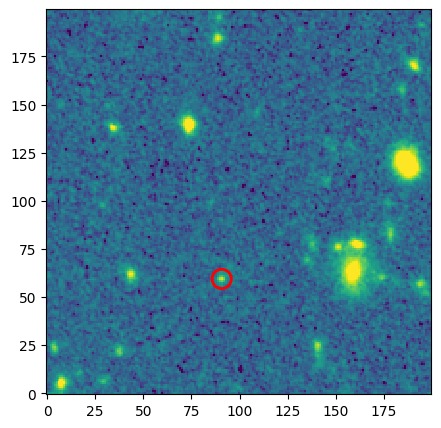

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(data, norm=norm)
aperture.plot(color='red', lw=2);

# Performing Aperture Photometry

Now let's perform photometry on the XDF data using this circular aperture.

After the aperture object is created, we can  perform the photometry using the [aperture_photometry()](https://photutils.readthedocs.io/en/latest/api/photutils.aperture.aperture_photometry.html#photutils.aperture.aperture_photometry) function or the [ApertureStats](https://photutils.readthedocs.io/en/latest/api/photutils.aperture.ApertureStats.html#photutils.aperture.ApertureStats) class.  We'll start by using the `aperture_photometry()` function.  The `ApertureStats` class will be introduced later in this notebook.

In the most basic case, we simply need to input the data array and the aperture object. The default aperture overlap method is `'exact'`.

Note that the input data array is assumed to be background subtracted.  If that is not the case, please see the documentation for the [photutils.background](https://photutils.readthedocs.io/en/latest/background.html) subpackage for tools to help subtract the background.

The background has already been subtracted from our XDF example data, so we skip that step in this example.

<div class="alert alert-warning alert-block">
<h3 style="margin-top:0;">Learn More</h3>

See the [local background subtraction notebook](03-aperture_local_bkgsub.ipynb) for examples of aperture photometry with local background subtraction.
</div>

In [11]:
from photutils.aperture import aperture_photometry

phot = aperture_photometry(data, aperture)
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,90.73,59.43,0.12039154582527045


The output is an Astropy `QTable` (Quantity Table) with several columns.  The sum of the data values within the circular aperture is in the `aperture_sum` column.

The table also contains metadata, which is accessed by the `meta` attribute of the table.  The metadata is stored in a python dictionary.

In [12]:
phot.meta

OrderedDict([('date', '2024-01-07 14:19:06 CST'),
             ('version',
              {'Python': '3.11.7',
               'photutils': '1.10.0',
               'astropy': '6.0.0',
               'numpy': '1.26.3',
               'scipy': '1.11.4',
               'skimage': '0.22.0',
               'sklearn': None,
               'matplotlib': '3.8.2',
               'gwcs': '0.20.0',
               'bottleneck': None}),
             ('aperture_photometry_args', "method='exact', subpixels=5")])

In [13]:
phot.meta['aperture_photometry_args']

"method='exact', subpixels=5"

The other aperture overlap methods are specified using the `method` keyword.  Aperture photometry using the **'center'** method gives a slightly less accurate answer.

In [14]:
phot = aperture_photometry(data, aperture, method='center')
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,90.73,59.43,0.1202922910979396


Now perform aperture photometry using the `'subpixel'` method with `subpixels=5`:

These parameters are equivalent to SourceExtractor aperture photometry.

In [15]:
phot = aperture_photometry(data, aperture, method='subpixel', subpixels=5)
phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,90.73,59.43,0.12040869806049158


## Photometric Errors

We can also input an error array to get the photometric errors.

In [16]:
phot = aperture_photometry(data, aperture, error=error)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008021175633656936


The error keyword expects the **total** error array (i.e., all sources of error).

However, the error array in our XDF FITS file represents only the background error.  Thus, we need to also include the source Poisson error as follows:

$\sigma_{\mathrm{tot}} = \sqrt{\sigma_{\mathrm{b}}^2 + \frac{I}{g}}$
  
where $\sigma_{\mathrm{tot}}$ is the total error (in the same units as the data), $\sigma_{\mathrm{b}}$ is the background-only error, $I$ are the data values, and $g$ is the "effective gain".

The "effective gain" is the value (or an array if it's variable across an image) needed to convert the data image to count units (e.g., electrons or photons), where Poisson statistics apply.

Photutils provides a [calc_total_error()](https://photutils.readthedocs.io/en/stable/api/photutils.utils.calc_total_error.html) function to perform the calculation of combining background-only error with the source Poisson error.

In [17]:
# this time include the Poisson error of the source
from photutils.utils import calc_total_error

# our data array is in units of e-/s
# so the "effective gain" should be the exposure time
eff_gain = hdr['TEXPTIME']  # exposure time from the FITS header
total_error = calc_total_error(data, error, eff_gain)

phot = aperture_photometry(data, aperture, error=total_error)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417


The aperture photometry error increased only slightly because this is a small faint source.

## Units

`Quantity` inputs for the `data` and `error` arrays are also allowed.  Note that the unit must be the same for the `data` and `error` inputs.

The XDF dataset has units of electron/s. One way to check this is to look at the value of the `BUNIT` FITS header keyword.

In [18]:
hdr['BUNIT']

'ELECTRONS/S'

In [19]:
import astropy.units as u

unit = u.electron / u.s  # unit for the data and error arrays
phot = aperture_photometry(data << unit, aperture, error=total_error << unit)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,electron / s
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417


The table columns now contain `Quantity` arrays.

In [20]:
phot['aperture_sum']

<Quantity [0.12039155] electron / s>

## Performing aperture photometry for multiple sources

Now let's perform aperture photometry for three sources (all with the same aperture size).  We simply define three (x, y) positions.

In [21]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radius = 5.0  # pixels
apertures = CircularAperture(positions, r=radius)

In [22]:
apertures

<CircularAperture([[ 90.73,  59.43],
                 [ 73.63, 139.41],
                 [ 43.62,  61.63]], r=5.0)>

Note that an aperture object with multiple positions can be indexed or sliced to get a subset of apertures:

In [23]:
apertures[1]  # aperture for the second position

<CircularAperture([ 73.63, 139.41], r=5.0)>

In [24]:
apertures[0:2]  # apertures for the first two positions

<CircularAperture([[ 90.73,  59.43],
                 [ 73.63, 139.41]], r=5.0)>

Let's plot all three apertures on the data.

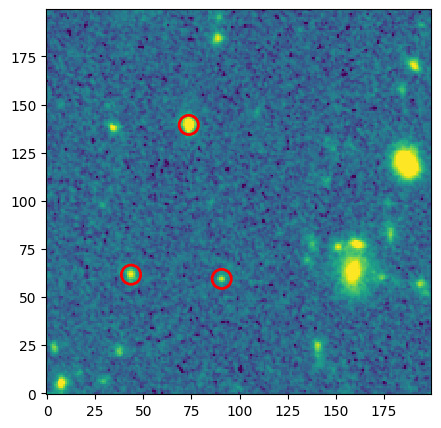

In [25]:
plt.figure(figsize=(5, 5))
plt.imshow(data, norm=norm)
apertures.plot(color='red', lw=2);

Now let's perform aperture photometry for these three sources.

In [26]:
phot = aperture_photometry(data << unit, apertures, error=total_error << unit)
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,electron / s
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417
2,73.63,139.41,0.6150243632978062,0.00816628074162013
3,43.62,61.63,0.213526159948924,0.008069761430877865


Each source is a row in the table and is given a unique **`id`** number (the first column).

Since we input arrays with units, the output columns are `Quantity` arrays.

In [27]:
phot['aperture_sum']

<Quantity [0.12039155, 0.61502436, 0.21352616] electron / s>

## Adding columns to the photometry table

Let's calculate the signal-to-noise (SNR) ratio of our sources and add it as a new column to the table.

In [28]:
snr = phot['aperture_sum'] / phot['aperture_sum_err']  # units will cancel
phot['snr'] = snr
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr
,pix,pix,electron / s,electron / s,
int64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988
2,73.63,139.41,0.6150243632978062,0.00816628074162013,75.3126646948694
3,43.62,61.63,0.213526159948924,0.008069761430877865,26.46003376653672


As mentioned above, this dataset was taken with the HST WFC3/IR F160W filter.  Using the [F160W zero point](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/ir-photometric-calibration), let's calculate the F160W AB magnitude and it as a new column in the table.

In [29]:
f160w_zpt = 25.9463  # HST/WFC3 F160W ABmag zero point for flux in e-/s

# NOTE that the log10() function can be applied only to dimensionless quantities,
# so we use the value attribute for Quantity objects to remove the units of the aperture sum
abmag = -2.5 * np.log10(phot['aperture_sum'].value) + f160w_zpt

phot['f160w_abmag'] = abmag
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,f160w_abmag
,pix,pix,electron / s,electron / s,,
int64,float64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352
2,73.63,139.41,0.6150243632978062,0.00816628074162013,75.3126646948694,26.474069199845104
3,43.62,61.63,0.213526159948924,0.008069761430877865,26.46003376653672,27.62267227553782


Using the `WCS` transform defined when we loaded the data, we can also calculate the sky coordinates for these objects and add it to the table.

In [30]:
# convert pixel positions to sky coordinates
x, y = np.transpose(positions)
sky_coord = wcs.pixel_to_world(x, y)  # a SkyCoord object

# we can add the astropy SkyCoord object directly to the table
phot['sky_coord'] = sky_coord
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,f160w_abmag,sky_coord
,pix,pix,electron / s,electron / s,,,"deg,deg"
int64,float64,float64,float64,float64,float64,float64,SkyCoord
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352,"53.158891500867604,-27.765002141410175"
2,73.63,139.41,0.6150243632978062,0.00816628074162013,75.3126646948694,26.474069199845104,"53.15921313626186,-27.763669058236427"
3,43.62,61.63,0.213526159948924,0.008069761430877865,26.46003376653672,27.62267227553782,"53.159778816470286,-27.764965241221894"


In [31]:
phot['sky_coord']  # a SkyCoord object

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(53.1588915 , -27.76500214), (53.15921314, -27.76366906),
     (53.15977882, -27.76496524)]>

## Saving a photometry table

If we write the table to an ASCII file using the ECSV format, we can read it back in later preserving all of the table metadata and `Quantity` and `SkyCoord` objects.

In [32]:
aper_filename = 'f160w_aperture_photometry.ecsv'
phot.write(aper_filename, overwrite=True)

Now let's read the table into a new variable.

In [33]:
from astropy.table import QTable

tbl = QTable.read(aper_filename)
tbl

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,f160w_abmag,sky_coord
,pix,pix,electron / s,electron / s,,,"deg,deg"
int64,float64,float64,float64,float64,float64,float64,SkyCoord
1,90.73,59.43,0.12039154582527045,0.008044023150701417,14.966583706906988,28.24481002294352,"53.158891500867604,-27.765002141410175"
2,73.63,139.41,0.6150243632978062,0.00816628074162013,75.3126646948694,26.474069199845104,"53.15921313626186,-27.763669058236427"
3,43.62,61.63,0.213526159948924,0.008069761430877865,26.46003376653672,27.62267227553782,"53.159778816470286,-27.764965241221894"


In [34]:
# the table metadata was preserved
tbl.meta

OrderedDict([('date', '2024-01-07 14:22:38 CST'),
             ('version',
              {'Python': '3.11.7',
               'astropy': '6.0.0',
               'bottleneck': None,
               'gwcs': '0.20.0',
               'matplotlib': '3.8.2',
               'numpy': '1.26.3',
               'photutils': '1.10.0',
               'scipy': '1.11.4',
               'skimage': '0.22.0',
               'sklearn': None}),
             ('aperture_photometry_args', "method='exact', subpixels=5")])

In [35]:
# as was the Quantity arrays, e.g.:
tbl['aperture_sum']

<Quantity [0.12039155, 0.61502436, 0.21352616] electron / s>

In [36]:
# and the SkyCoord array
tbl['sky_coord']

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(53.1588915 , -27.76500214), (53.15921314, -27.76366906),
     (53.15977882, -27.76496524)]>

## Aperture photometry using Sky apertures

Aperture photometry can also be performed using `SkyCoord` positions instead of pixel positions.

First, let's define the sky coordinates by converting our pixel coordinates.

In [37]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
x, y = np.transpose(positions)
coord = wcs.pixel_to_world(x, y)
coord

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(53.1588915 , -27.76500214), (53.15921314, -27.76366906),
     (53.15977882, -27.76496524)]>

Now let's define circular apertures centered at these sky coordinates.

For sky apertures, the aperture radius must be a `Quantity` in angular units.

In [38]:
from photutils.aperture import SkyCircularAperture

radius = 0.5 * u.arcsec  # angular units
sky_apers = SkyCircularAperture(coord, r=radius)
sky_apers.r

<Quantity 0.5 arcsec>

When performing photometry using a sky aperture, `aperture_photometry` needs the WCS transformation, which is input via the `wcs` keyword.

In [39]:
phot_sky = aperture_photometry(data, sky_apers, wcs=wcs)
phot_sky

id,xcenter,ycenter,sky_center,aperture_sum
,pix,pix,"deg,deg",
int64,float64,float64,SkyCoord,float64
1,90.7299999992756,59.42999999987751,"53.158891500867604,-27.765002141410175",0.14686113555048344
2,73.62999999953081,139.40999999869337,"53.15921313626186,-27.763669058236427",0.7507009964301674
3,43.61999999942509,61.629999999655865,"53.159778816470286,-27.764965241221894",0.2695146875369733


# ApertureStats

The [ApertureStats](https://photutils.readthedocs.io/en/latest/api/photutils.aperture.ApertureStats.html#photutils.aperture.ApertureStats) class can be used to create a catalog of statistics and properties for pixels within an aperture, including aperture photometry. 

It can calculate many properties, including statistics like `min`, `max`, `mean`, `median`, `std`, `sum_aper_area`, and `sum`. It also can be used to calculate morphological properties like `centroid`, `fwhm`, `semimajor_sigma`, `semiminor_sigma`, `orientation`, and `eccentricity`. Please see `ApertureStats` for the the complete list of properties that can be calculated. The properties can be accessed using `ApertureStats` attributes or output to an Astropy `QTable` using the `to_table()` method.

Most of the source properties are calculated using the "center" aperture-mask method, which gives aperture weights of 0 or 1. This avoids the need to compute weighted statistics -- the data pixel values are directly used.

The `sum_method` and `subpixels` keywords are used to determine the aperture-mask method when calculating the sum-related properties: `sum`, `sum_error`, `sum_aper_area`, `data_sumcutout`, and `error_sumcutout`. The default is `sum_method='exact'`, which produces exact aperture-weighted photometry.

The optional `local_bkg` keyword can be used to input the per-pixel local background of each source, which will be subtracted before computing the aperture statistics.

The optional `sigma_clip` keyword can be used to sigma clip the pixel values before computing the source properties. This keyword could be used, for example, to compute a sigma-clipped median of pixels in an annulus aperture to estimate the local background level.

Note that like `aperture_photometry()`, `ApertureStats` expects the input data to be background subtracted.  The background has already been subtracted from our XDF example data, so we skip that step in this example.

As before, we start by creating an `Aperture` object.

In [40]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radius = 5.0  # pixels
apertures = CircularAperture(positions, r=radius)

Now let's create an `ApertureStats` object.

In [41]:
from photutils.aperture import ApertureStats

apstats = ApertureStats(data << unit, apertures, error=total_error << unit)
apstats

<photutils.aperture.stats.ApertureStats>
Length: 3

The source properties can be accessed as attributes, for example the source sum (and errors) for aperture photometry.

In [42]:
apstats.sum

<Quantity [0.12039155, 0.61502436, 0.21352616] electron / s>

In [43]:
apstats.sum_err

<Quantity [0.00804402, 0.00816628, 0.00806976] electron / s>

Note that these values are exactly the same as those calculated earlier using `aperture_photometry()`.

In [44]:
phot['aperture_sum'], phot['aperture_sum_err']

(<Quantity [0.12039155, 0.61502436, 0.21352616] electron / s>,
 <Quantity [0.00804402, 0.00816628, 0.00806976] electron / s>)

Going further, here are the calculated source centroids.

In [45]:
apstats.xcentroid, apstats.ycentroid

(array([91.09756548, 73.65265559, 43.6006078 ]),
 array([ 59.45777419, 139.44833928,  61.53398221]))

All of the source properties can be output as an astropy `QTable` using the `to_table()` method.

In [46]:
apstats.to_table()

id,xcentroid,ycentroid,sky_centroid,sum,sum_err,sum_aper_area,center_aper_area,min,max,mean,median,mode,std,mad_std,var,biweight_location,biweight_midvariance,fwhm,semimajor_sigma,semiminor_sigma,orientation,eccentricity
,,,,electron / s,electron / s,pix2,pix2,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,electron2 / s2,electron / s,electron2 / s2,pix,pix,pix,deg,
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,91.09756547625157,59.45777419342555,None,0.12039154582527045,0.008044023150701417,78.53981633974483,81.0,-0.0005713407299481332,0.007200807798653841,0.0014850900135548097,0.001009436440654099,5.812929485267751e-05,0.001656474962305691,0.0009289215689306939,2.7439093007456405e-06,0.0009451296378208286,1.1489180016092313e-06,4.135732705221973,1.9321749220635414,1.560694352098792,65.14428042288418,0.5895393204166948
2,73.65265559061824,139.44833927814233,None,0.6150243632978062,0.00816628074162013,78.53981633974483,80.0,0.001133664045482874,0.02507632039487362,0.007740425039082765,0.005494937300682068,0.0010039618238806731,0.005811872338457792,0.0037728271323393633,3.377786007853085e-05,0.005711147934776642,2.208104599262193e-05,4.683412899671711,2.107080744730346,1.8631579460673597,-82.41218018814325,0.4670391932258404
3,43.6006077991013,61.53398221166813,None,0.213526159948924,0.008069761430877865,78.53981633974483,81.0,0.00040297224768437445,0.008772757835686207,0.002682973751812644,0.00215523480437696,0.001099756909505591,0.001870572962312253,0.0012403589481386622,3.499043207333637e-06,0.002128543738737444,2.357261229526718e-06,4.883415818525052,2.2174617568531514,1.9194064297733509,-74.81391838824608,0.5007582893415568


# Exercise

Measure the circular-aperture fluxes (and errors) of the three sources centered at (x, y) positions of `(34.61, 137.99), (184.53, 157.52), and (88.75, 184.22)` within a radius of `4.5` pixels.

Calculate their signal-to-noise ratios and F160W magnitudes.

Plot the apertures on the data.

Hints:

* The HST/WFC3 F160W ABmag zero point for data in units of e-/s is `25.9463`.

If you prefer to load the solution, for each cell below uncomment the cell and **run it twice** (once to load the solution and once more to run it).

In [ ]:
# %load 01-aperture_exercise_solution

In [ ]:
# %load 01-aperture_exercise_solution_plot

<div class="alert alert-warning alert-block">
<h3 style='margin-top: 0;'>Learn More</h3>

The [aperture photometry extended notebook](02-aperture_extended.ipynb) covers:

- Aperture Photometry
    - Performing aperture photometry at multiple positions with the same aperture
      - Using the aperture_photometry() function
      - Using the ApertureStats class
    - Performing aperture photometry at multiple positions using different apertures
      - Using the aperture_photometry() function
      - Using the ApertureStats class
    - Bad pixel masking
      - Using the aperture_photometry() function
      - Using the ApertureStats class
    - Encircled flux
      - Using the aperture_photometry() function
      - Using the ApertureStats class

- ApertureMask objects
</div>